In [25]:
from compton.Functions import *
from compton.Analysis import *
from positron.Dataloader import *
from positron.Analysis import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import muon.Dataloader as dl
from muon.Analysis import *
from muon.Functions import *

Part 1: AB coincidence Analysis

,A*B,A*B*T
Voltage,,
500,1118,4
550,1049,1
600,1092,3
650,1118,3
700,1160,4


trials =  23
gamma (per microsecond) =  1.7922463768115943e-05
Standard deviation of sum 157.26728839781018
Mean of A*B counts (gamma) per minute: 1075.3478260869565
Theoretical population standard deviation: 32.79249649061438
Unbiased population Standard Deviation: 40.387451579163645
Theoretical standard deviation of mean (std_sum / M): 6.837708191209138
Thoretical standard deviation of mean, as sqrt(Nbar)/sqrtM: 6.837708191209139
experimental standard deviation of sum  over trials: 8.421365801287788


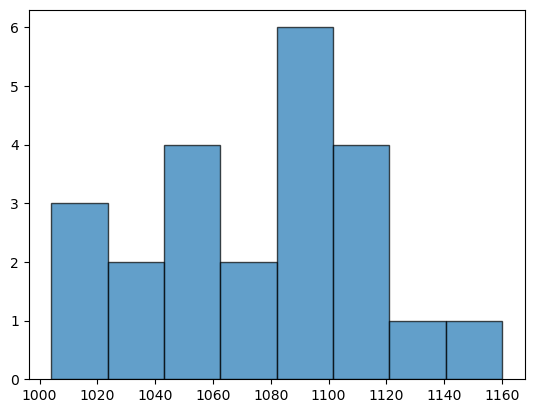

In [26]:
df_ABT = dl.load_ABT_txt("../Databases/ABT_24.txt")
display(df_ABT.head())
ABcounts =df_ABT["A*B"].to_numpy()
plt.hist(ABcounts, bins=8, alpha=0.7, edgecolor='black')
print("trials = ", len(ABcounts))
std_unbiased = np.std(ABcounts, ddof=1)
n_total=ABcounts.sum()
sig_sum= np.sqrt(n_total)
Nbar = np.mean(ABcounts)
gamma = Nbar/(60 *1e6) # per microsecond
print("gamma (per microsecond) = "   , gamma)
print(f"Standard deviation of sum {sig_sum}")
print(f"Mean of A*B counts (gamma) per minute: {Nbar}")
print(f"Theoretical population standard deviation: {np.sqrt(Nbar)}")
print(f"Unbiased population Standard Deviation: {std_unbiased}")
print(f"Theoretical standard deviation of mean (std_sum / M): {sig_sum/len(ABcounts)}")
print(f"Thoretical standard deviation of mean, as sqrt(Nbar)/sqrtM: {np.sqrt(Nbar)/np.sqrt(len(ABcounts))}")
print(f"experimental standard deviation of sum  over trials: {std_unbiased/np.sqrt(len(ABcounts))}")

Part 2: Uncorrected Decay data

,count
time (microseconds),
0.080,869
0.088,869
0.096,908
0.104,895
0.112,876
...,...
8.152,25
8.160,20
8.168,27


[0.08  0.088 0.096 ... 8.168 8.176 8.184]


Text(0.75, 0.95, 'A = 909.9312\nτ = 2.089169930\n $\\sigma_A$ = 2.333840863\n $\\sigma_\\tau$ = 0.007363667')

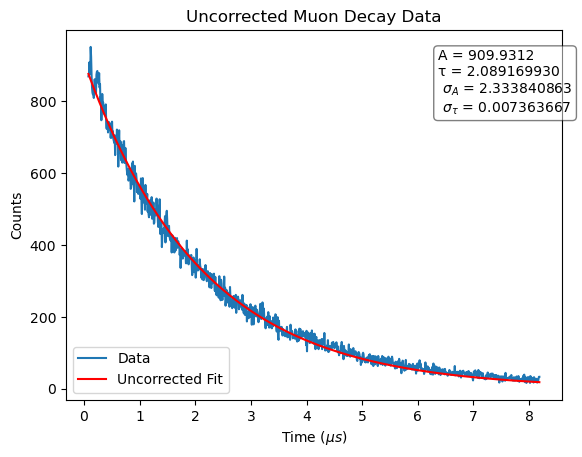

In [27]:
df = dl.load_muon_decay_txt("../Databases/muon_decay_combined_2025.txt")
display(df)
times = df.index.values
print(times)
counts = df['count'].values
popt, pcov = curve_fit(exponential_decay, times, counts, p0=(900, 1))
fit = exponential_decay(times, *popt)
plt.plot(times, counts, label='Data')
plt.plot(times, fit, label='Uncorrected Fit', color='red')
plt.legend()
plt.title("Uncorrected Muon Decay Data")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Counts")

fit_params_text =f"A = {popt[0]:.4f}\nτ = {popt[1]:.9f}\n $\sigma_A$ = {np.sqrt(pcov[0][0]):.9f}\n $\\sigma_\\tau$ = {np.sqrt(pcov[1][1]):.9f}"
plt.text(0.75, 0.95, fit_params_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))


Part 3: correcting for background

Our correction reforulates the fit as a standard decreasing exponential, but with an added linear term $\gamma t$, where $\gamma$ is the AB background rate obtained from part 1 of the analysis.

Text(0.75, 0.95, 'A = 909.9313\nτ = 2.089169125\n $\\sigma_A$ = 2.333838871\n $\\sigma_\\tau$ = 0.007363656')

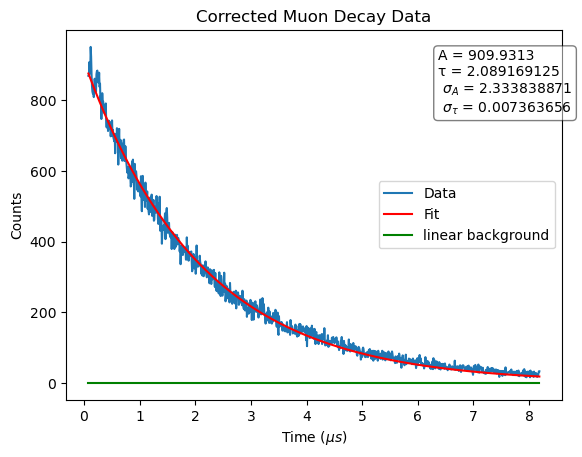

In [28]:
fixed_gamma = lambda t, a, tau: corrected_exponential_decay(t, a, tau, gamma) #using a lambda function to fix gamma to the result obtained from the ABT data
popt, pcov = curve_fit(fixed_gamma, times, counts, p0=(900, 1))
fit = fixed_gamma(times, *popt)


plt.plot(times, counts, label='Data')
plt.plot(times, fit, label='Fit', color='red')
plt.plot(times, gamma*times, label="linear background" , color='green')
plt.legend()
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Counts")
plt.title("Corrected Muon Decay Data")

corrected_params_text = f"A = {popt[0]:.4f}\nτ = {popt[1]:.9f}\n $\sigma_A$ = {np.sqrt(pcov[0][0]):.9f}\n $\\sigma_\\tau$ = {np.sqrt(pcov[1][1]):.9f}"
plt.text(0.75, 0.95, corrected_params_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))